In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd

# Example: if your dataset has a file called resumes.csv
df = pd.read_csv('/kaggle/input/truncated-resume/Truncated_Resume.csv')
df.head()

,Resume,Job_Description,Category,Type,Score,Resume_truncated,Job_Description_truncated
0,database administrator family private care llc...,database administrator a database analyst exam...,Database Administrator,positive,85.00,database administrator family private care llc...,database administrator a database analyst exam...
1,database administrator family private care llc...,database administrator a database analyst exam...,Database Administrator,semi-negative,60.00,database administrator family private care llc...,database administrator a database analyst exam...
2,database administrator family private care llc...,java developer java backend developers special...,Database Administrator→Java Developer,negative,30.00,database administrator family private care llc...,java developer java backend developers special...
3,database administrator database administrator ...,database administrator a database developer de...,Database Administrator,positive,85.38,database administrator database administrator ...,database administrator a database developer de...
4,database administrator database administrator ...,database administrator a database developer de...,Database Administrator,semi-negative,60.00,database administrator database administrator ...,database administrator a database developer de...


In [2]:
!python --version

Python 3.11.11


In [3]:
!pip install torch>=2.0.0 \
            transformers>=4.39.0 \
            datasets>=2.17.0 \
            scikit-learn \
            matplotlib \
            pandas \
            tqdm \
            notebook \
            ipywidgets


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-cu12 25.2.0 which is incompatible.


In [4]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

2.5.1+cu124
12.4
Tesla P100-PCIE-16GB


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

2025-05-06 19:43:01.665676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746560581.860772      32 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746560581.916457      32 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [8]:
class ResumeJDDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = tokenizer(
            row['Resume_truncated'],
            row['Job_Description_truncated'],
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        inputs['labels'] = torch.tensor(row['Score'], dtype=torch.float)
        return inputs

In [9]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
train_dataset = ResumeJDDataset(train_df)
val_dataset = ResumeJDDataset(val_df)

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1  # Regression
)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [11]:
training_args = TrainingArguments(
    output_dir="./deberta-regressor",
    run_name="deberta_resume_run",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    fp16=True,  # ✅ Mixed precision
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
    
)

In [12]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.flatten()
    mse = np.mean((predictions - labels) ** 2)
    return {"mse": mse}

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [14]:
trainer.train()

Step,Training Loss,Validation Loss,Mse
1000,526.332300,515.436279,515.436279
2000,499.246900,529.225647,529.225647
3000,476.611200,516.765930,516.765930
4000,523.741900,512.797485,512.797424
5000,502.078400,515.611389,515.611389
6000,502.856900,549.934875,549.934875
7000,537.189000,510.811188,510.811188
8000,494.736200,507.061279,507.061279
9000,539.542200,514.350708,514.350708
10000,548.008100,508.341431,508.341431


TrainOutput(global_step=22665, training_loss=535.7420913733317, metrics={'train_runtime': 19464.1829, 'train_samples_per_second': 9.316, 'train_steps_per_second': 1.164, 'total_flos': 4.770456642747187e+16, 'train_loss': 535.7420913733317, 'epoch': 2.9996691152140826})

In [15]:
# ✅ Step 12: Plot Loss
training_logs = trainer.state.log_history
loss_values = [log['loss'] for log in training_logs if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]

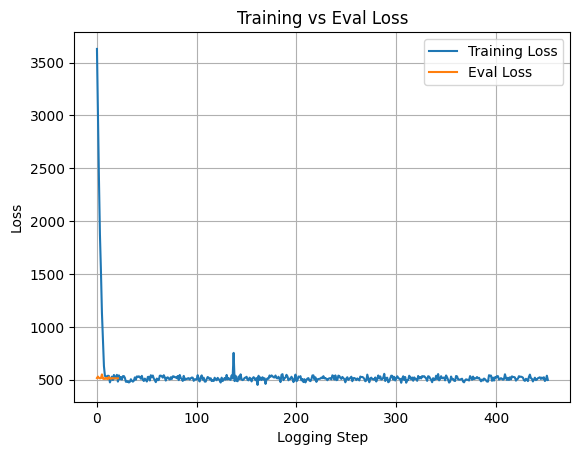

In [16]:
plt.plot(loss_values, label="Training Loss")
plt.plot(eval_loss_values, label="Eval Loss")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.title("Training vs Eval Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()

In [17]:
# ✅ Step 13: Save final model
model.save_pretrained("./deberta-regressor")
tokenizer.save_pretrained("./deberta-regressor")

('./deberta-regressor/tokenizer_config.json',
 './deberta-regressor/special_tokens_map.json',
 './deberta-regressor/spm.model',
 './deberta-regressor/added_tokens.json',
 './deberta-regressor/tokenizer.json')

In [ ]:
import shutil
shutil.make_archive("deberta-regressor", 'zip', "./deberta-regressor")